# Dask Implementation

In [1]:
import numpy as np
import pandas as pd
import warnings
import time
import dask
import dask.dataframe as dd
import matplotlib.pyplot as plt
from dask.distributed import Client
from dask_ml.cluster import KMeans
from dask_ml.linear_model import LogisticRegression, LinearRegression

SEED = 42

In [2]:
warnings.filterwarnings("ignore")

In [3]:
client = Client('172.31.88.97:8786')
client = client.restart()
print(client)

<Client: 'tcp://172.31.88.97:8786' processes=0 threads=0, memory=0 B>


In [7]:
testx, testy = make_classification()

In [8]:
testx.shape

(1000, 100)

In [10]:
testx

dask.array<normal, shape=(1000, 100), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [9]:
testy.shape

(1000,)

## Read data

In [4]:
# Split data into X and y
X_reg_train = pd.read_csv('/home/ubuntu/data/X_reg_train.csv')
X_reg_test = pd.read_csv('/home/ubuntu/data/X_reg_test.csv')

X_class_train = pd.read_csv('/home/ubuntu/data/X_class_train.csv')
X_class_test = pd.read_csv('/home/ubuntu/data/X_class_test.csv')

y_reg_train = pd.read_csv('/home/ubuntu/data/y_reg_train.csv')
y_reg_test = pd.read_csv('/home/ubuntu/data/y_reg_test.csv')

y_class_train = pd.read_csv('/home/ubuntu/data/y_class_train.csv')
y_class_test = pd.read_csv('/home/ubuntu/data/y_class_test.csv')

In [35]:
X_class_train_subset = X_class_train.head(int(len(X_class_train) * 0.1))

In [36]:
X_class_train_subset.shape[0]

1600000

In [37]:
dask_train = dd.from_pandas(X_class_train_subset)

In [38]:
dask_train.shape[0].compute()

1600000.0

In [39]:
dask_arr_train = dask_train.to_dask_array(lengths=True)

/home/ubuntu/.local/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 48.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [40]:
dask_arr_train

dask.array<values, shape=(1600000, 4), dtype=float64, chunksize=(1600000, 4), chunktype=numpy.ndarray>

In [41]:
y_class_train_subset = y_class_train.head(int(len(y_class_train) * 0.1))
dask_lab = dd.from_pandas(y_class_train_subset)
dask_lab_arr = dask_lab.to_dask_array(lengths=True)

/home/ubuntu/.local/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 12.21 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [42]:
dask_lab_arr

dask.array<values, shape=(1600000, 1), dtype=int64, chunksize=(1600000, 1), chunktype=numpy.ndarray>

In [43]:
lr = LogisticRegression()
lr.fit(dask_arr_train, dask_lab_arr)

/home/ubuntu/.local/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 48.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 61.04 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


LogisticRegression()

In [85]:
preds = lr.predict(dd.from_pandas(X_class_test).to_dask_array(lengths=True))

/home/ubuntu/.local/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 122.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [91]:
np.equal(preds, dd.from_pandas(y_class_test).to_dask_array(lengths=True).T).mean().compute()

/home/ubuntu/.local/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 30.52 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 152.59 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


0.734008

In [77]:
np_preds = np.array(preds)

/home/ubuntu/.local/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 122.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [84]:
np.equal(np_preds, np.array(y_class_test.T)).mean()

0.734008

## Dask Experiment Function

In [5]:
def dask_time_algorithm(subset_prop, algorithm_name, SEED=SEED):
    '''
    algorithm_name one of 'LogReg', 'LinReg', 'KMEANS'
    '''
    if (algorithm_name == "LinReg" or algorithm_name == "KMEANS"):
        X_reg_train_subset = dd.from_pandas(X_reg_train.head(int(len(X_reg_train) * subset_prop))).to_dask_array(lengths=True)
        X_reg_test_subset = dd.from_pandas(X_reg_test.head(int(len(X_reg_test) * subset_prop))).to_dask_array(lengths=True)
        y_reg_train_subset = dd.from_pandas(y_reg_train.head(int(len(y_reg_train) * subset_prop))).to_dask_array(lengths=True)
        y_reg_test_subset = dd.from_pandas(y_reg_test.head(int(len(y_reg_test) * subset_prop))).to_dask_array(lengths=True)

        # print(f'X_reg_train_subset shape {X_reg_train_subset.shape[0]}')
        # print(f'X_reg_test_subset shape {X_reg_test_subset.shape[0]}')
        # print(f'y_reg_train_subset shape {y_reg_train_subset.shape[0]}')
        # print(f'y_reg_test_subset shape {y_reg_test_subset.shape[0]}')
       
    elif (algorithm_name == "LogReg"):
        X_class_train_subset = dd.from_pandas(X_class_train.head(int(len(X_class_train) * subset_prop))).to_dask_array(lengths=True)
        X_class_test_subset = dd.from_pandas(X_class_test.head(int(len(X_class_test) * subset_prop))).to_dask_array(lengths=True)
        y_class_train_subset = dd.from_pandas(y_class_train.head(int(len(y_class_train) * subset_prop))).to_dask_array(lengths=True)
        y_class_test_subset = dd.from_pandas(y_class_test.head(int(len(y_class_test) * subset_prop))).to_dask_array(lengths=True)

        # print(f'X_class_train_subset shape {X_class_train_subset.shape[0]}')
        # print(f'X_class_test_subset shape {X_class_test_subset.shape[0]}')
        # print(f'y_class_train_subset shape {y_class_train_subset.shape[0]}')
        # print(f'y_class_test_subset shape {y_class_test_subset.shape[0]}')
       
    start_time = time.time()
       
    if algorithm_name == "LogReg":
        logreg = LogisticRegression()
        logreg.fit(X_class_train_subset, y_class_train_subset)
        preds = logreg.predict(X_class_test_subset)
        metric = np.equal(preds, y_class_test_subset.T).mean().compute()
                       
    elif algorithm_name == "KMEANS":
        n_clusters = 2
        kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
        # Fit the model to the data
        kmeans.fit(X_reg_train_subset)
        metric = None
        
    elif algorithm_name == "LinReg":
        linreg = LinearRegression()
        linreg.fit(X_reg_train_subset, y_reg_train_subset)
        preds = linreg.predict(X_reg_test_subset)
        metric = ((np.subtract(preds, y_reg_test_subset.T)**2).mean()).compute()
           
    end_time = time.time()
    time_delta = end_time - start_time
    return time_delta, metric

## Set proportions to loop over

In [6]:
props = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

## Logistic Regression Test

In [9]:
%%time
    logreg_times = []
    logreg_metrics = []
    
    for prop in props:
        print(prop)
        runtime, metric = dask_time_algorithm(prop, algorithm_name="LogReg")
        logreg_times.append(runtime)
        logreg_metrics.append(metric)
       
    print(logreg_times)
    print(logreg_metrics)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
[27.248703241348267, 32.137929916381836, 43.77782320976257, 64.51912760734558, 88.60880374908447, 94.01658797264099, 118.86120104789734, 133.5087571144104, 131.96815872192383, 142.8038866519928]
[0.73313, 0.73349125, 0.7335116666666667, 0.733558125, 0.7338895, 0.7338479166666667, 0.7339257142857143, 0.7339321875, 0.7339388888888889, 0.73398375]
CPU times: user 35.9 s, sys: 1min 7s, total: 1min 43s
Wall time: 15min 21s


In [11]:
logreg_frame = pd.DataFrame(list(zip(logreg_times, logreg_metrics)), columns=['Time', 'Metric'], index=props)
logreg_frame

,Time,Metric
0.1,27.248703,0.733130
0.2,32.137930,0.733491
0.3,43.777823,0.733512
0.4,64.519128,0.733558
0.5,88.608804,0.733889
0.6,94.016588,0.733848
0.7,118.861201,0.733926
0.8,133.508757,0.733932
0.9,131.968159,0.733939
1.0,142.803887,0.733984


In [15]:
logreg_frame.Time.sum()/60

14.624182987213135

Text(0, 0.5, 'Time (s)')

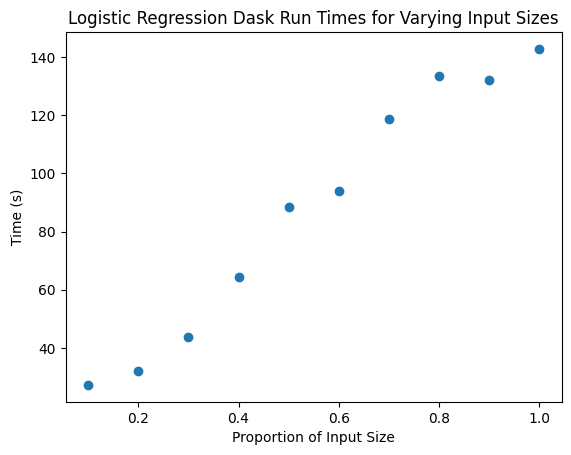

In [12]:
plt.scatter(x=logreg_frame.index, y=logreg_frame['Time'])
plt.title('Logistic Regression Dask Run Times for Varying Input Sizes')
plt.xlabel('Proportion of Input Size')
plt.ylabel('Time (s)')

In [13]:
logreg_frame.to_csv('dask_logreg_results.csv', index=True)

## KMeans Test

In [17]:
%%time
    kmeans_times = []
    kmeans_metrics = []
    
    for prop in props:
        print(prop)
        runtime, metric = dask_time_algorithm(prop, algorithm_name="KMEANS")
        kmeans_times.append(runtime)
        kmeans_metrics.append(metric)
       
    print(kmeans_times)
    print(kmeans_metrics)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
[39.69672632217407, 70.11089944839478, 94.51068902015686, 123.14445471763611, 171.68934750556946, 206.8264262676239, 228.91325211524963, 267.63171577453613, 293.77726316452026, 326.69960260391235]
[None, None, None, None, None, None, None, None, None, None]
CPU times: user 1min 56s, sys: 4min 12s, total: 6min 9s
Wall time: 31min 3s


In [19]:
kmeans_frame = pd.DataFrame(list(zip(kmeans_times, kmeans_metrics)), columns=['Time', 'Metric'], index=props)
kmeans_frame

,Time,Metric
0.1,39.696726,None
0.2,70.110899,None
0.3,94.510689,None
0.4,123.144455,None
0.5,171.689348,None
0.6,206.826426,None
0.7,228.913252,None
0.8,267.631716,None
0.9,293.777263,None
1.0,326.699603,None


In [28]:
kmeans_frame.Time.sum()/60

30.383339615662894

Text(0, 0.5, 'Time (s)')

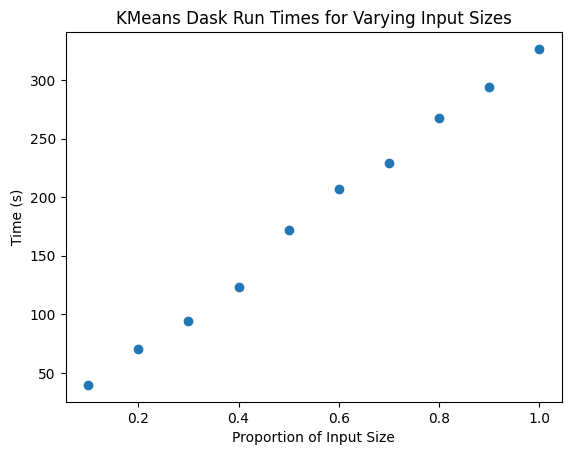

In [20]:
plt.scatter(x=kmeans_frame.index, y=kmeans_frame['Time'])
plt.title('KMeans Dask Run Times for Varying Input Sizes')
plt.xlabel('Proportion of Input Size')
plt.ylabel('Time (s)')

In [21]:
kmeans_frame.to_csv('dask_kmeans_new_results.csv', index=True)

## Linear Regression Test

In [22]:
%%time
    linreg_times = []
    linreg_metrics = []
    
    for prop in props:
        print(prop)
        runtime, metric = dask_time_algorithm(prop, algorithm_name="LinReg")
        linreg_times.append(runtime)
        linreg_metrics.append(metric)
       
    print(linreg_times)
    print(linreg_metrics)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
1.0
[10.847286701202393, 21.18761420249939, 31.768335342407227, 43.21693420410156, 51.52163338661194, 65.57311940193176, 70.45956420898438, 82.3525390625, 98.93277668952942, 108.03984069824219]
[0.66519063708539, 0.6664607365713493, 0.6681837204478563, 0.6715813864112423, 0.6715804381712097, 0.6714911534205328, 0.6710971945446953, 0.6712130503848568, 0.6699107084871396, 0.6701413053846041]
CPU times: user 35.9 s, sys: 1min 2s, total: 1min 38s
Wall time: 10min 23s


In [25]:
linreg_frame = pd.DataFrame(list(zip(linreg_times, linreg_metrics)), columns=['Time', 'Metric'], index=props)
linreg_frame

,Time,Metric
0.1,10.847287,0.665191
0.2,21.187614,0.666461
0.3,31.768335,0.668184
0.4,43.216934,0.671581
0.5,51.521633,0.671580
0.6,65.573119,0.671491
0.7,70.459564,0.671097
0.8,82.352539,0.671213
0.9,98.932777,0.669911
1.0,108.039841,0.670141


In [26]:
linreg_frame.Time.sum()/60

9.731660731633504

Text(0, 0.5, 'Time (s)')

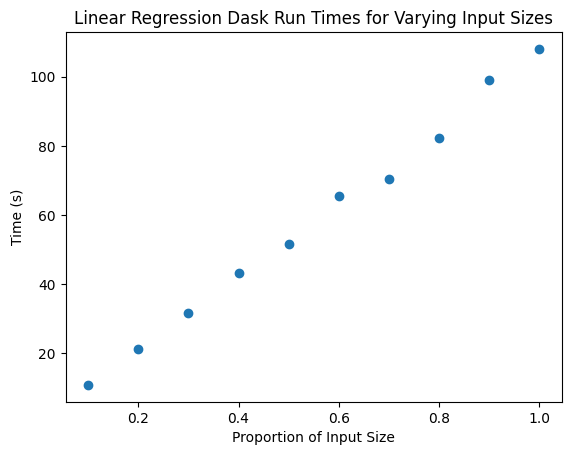

In [29]:
plt.scatter(x=linreg_frame.index, y=linreg_frame['Time'])
plt.title('Linear Regression Dask Run Times for Varying Input Sizes')
plt.xlabel('Proportion of Input Size')
plt.ylabel('Time (s)')

In [30]:
linreg_frame.to_csv('dask_linreg_results.csv', index=True)